In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import numpy as np

cpu


In [2]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 1 (x)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1, 5)
        self.hidden_layer2 = nn.Linear(5, 5)
        self.hidden_layer3 = nn.Linear(5, 5)
        self.hidden_layer4 = nn.Linear(5, 5)
        self.hidden_layer5 = nn.Linear(5, 5)
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x):
        #inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(x))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [3]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
## f = -lambda * du/dx
lambda_1 = torch.tensor(0.5)
def f(x, net):
    u = net(x)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    pde = 0.5 * u_x + u
    return pde

In [5]:
# setup boundary conditions
x0 = np.array([0.0])
u0 = np.array([5.0])

In [6]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
net.train()
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on initial conditions
    pt_x_bc = Variable(torch.from_numpy(x0).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u0).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on ODE
    x_collocation = np.random.uniform(low=0.0, high=20.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    
    # Combining the loss functions
    loss = mse_u + mse_f

    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
        print(epoch,"Traning Loss:",loss.data)

0 Traning Loss: tensor(20.0351)
1 Traning Loss: tensor(19.9987)
2 Traning Loss: tensor(19.9623)
3 Traning Loss: tensor(19.9260)
4 Traning Loss: tensor(19.8898)
5 Traning Loss: tensor(19.8537)
6 Traning Loss: tensor(19.8177)
7 Traning Loss: tensor(19.7817)
8 Traning Loss: tensor(19.7459)
9 Traning Loss: tensor(19.7102)
10 Traning Loss: tensor(19.6745)
11 Traning Loss: tensor(19.6390)
12 Traning Loss: tensor(19.6036)
13 Traning Loss: tensor(19.5682)
14 Traning Loss: tensor(19.5330)
15 Traning Loss: tensor(19.4979)
16 Traning Loss: tensor(19.4628)
17 Traning Loss: tensor(19.4279)
18 Traning Loss: tensor(19.3931)
19 Traning Loss: tensor(19.3584)
20 Traning Loss: tensor(19.3238)
21 Traning Loss: tensor(19.2893)
22 Traning Loss: tensor(19.2549)
23 Traning Loss: tensor(19.2206)
24 Traning Loss: tensor(19.1864)
25 Traning Loss: tensor(19.1524)
26 Traning Loss: tensor(19.1184)
27 Traning Loss: tensor(19.0846)
28 Traning Loss: tensor(19.0508)
29 Traning Loss: tensor(19.0172)
30 Traning Loss: ten

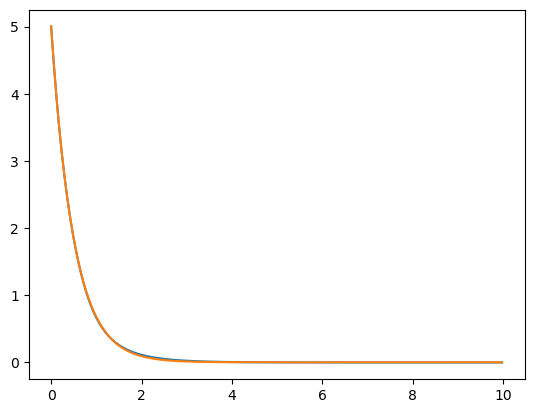

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

net.eval()

fig = plt.figure()

x=np.arange(0,10,0.02)
ms_x = np.meshgrid(x)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)

c = np.log(5)
u_e = np.exp(-2 * x + c)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()

plt.plot(x, u)
plt.plot(x, u_e)
plt.show()